# Training ResNet on CIFAR-10
In this project, you will use the SimpleNN model to perform image classification on CIFAR-10. CIFAR-10 orginally contains 60K images from 10 categories. We split it into 45K/5K/10K images to serve as train/valiation/test set. We only release the ground-truth labels of training/validation dataset to you.

## Step 0: Set up the ResNet model
As you have practiced to implement simple neural networks in Homework 1, we just prepare the implementation for you.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [13]:
# define the Residual Block for the ResNet-20 model;

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, device = 'cuda'):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, stride = 1, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels, out_channels, stride = 2, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(out_channels, out_channels, stride = 1, kernel_size = 3, padding = 1)
        self.conv_bottleneck = None
        self.in_channels = in_channels
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        if self.in_channels == self.out_channels:
          out = F.relu(self.bn1(self.conv1(x)))
          out = self.bn1(self.conv1(out))
        else:
          out = F.relu(self.bn1(self.conv2(x)))
          out = self.bn1(self.conv3(out))

        if x.size(1) != out.size(1): #add bottleneck if output filters in Y changes
            self.conv_bottleneck = nn.Conv2d(x.size(1), out.size(1), kernel_size=1, stride = 2)
            x = x.to("cpu")
            residual = nn.BatchNorm2d(out.size(1))(self.conv_bottleneck(x))
            x = x.to("cuda")
            residual = residual.to("cuda")

        out += residual
        out = F.relu(out)
        return out

# define ResNet-20 model

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.bn = nn.BatchNorm2d(16)
        self.conv_block1 = ResidualBlock(16, 16, 1) #32 - is this right??
        self.conv_block16 = ResidualBlock(16, 32, 2)
        self.conv_block2 = ResidualBlock(32, 32, 2) #16
        self.conv_block26 = ResidualBlock(32, 64, 2)
        self.conv_block3 = ResidualBlock(64, 64, 2) #8
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = F.relu(self.bn(self.conv1(x))) #1
        out = self.conv_block1(out) # 2, 3
        out = self.conv_block1(out) # 4, 5
        out = self.conv_block1(out) # 6, 7
        out = self.conv_block16(out) # 8, 9
        out = self.conv_block2(out) # 10, 11
        out = self.conv_block2(out) # 12, 13
        out = self.conv_block26(out) # 14, 15
        out = self.conv_block3(out) # 16, 17
        out = self.conv_block3(out) # 18, 19
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.softmax(self.fc(out)) #20
        return out

### Question (a)
Here is a sanity check to verify the implementation of SimpleNN.
You need to:
1. Write down your code.
2. **In the PDF report**, give a brief description on how the code helps you know that SimpleNN is implemented correctly.

In [14]:
#############################################
# your code here
# sanity check for the correctness of SimpleNN

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device: ", device)

# Model Definition
net = ResNet()
net = net.to(device)

# Test forward pass
data = torch.randn(2,3,32,32)
data = data.to(device)
# Forward pass "data" through "net" to get output "out"
out = net(data)

# Check output shape
assert(out.detach().cpu().numpy().shape == (2,10))
print("Forward pass successful")

#############################################

Using device:  cuda
Forward pass successful


## Step 1: Set up preprocessing functions
Preprocessing is very important as discussed in the lecture.
You will need to write preprocessing functions with the help of *torchvision.transforms* in this step.
You can find helpful tutorial/API at [here](https://pytorch.org/vision/stable/transforms.html).

### Question (b)
For the question, you need to:
1. Complete the preprocessing code below.
2. **In the PDF report**, briefly describe what preprocessing operations you used and what are the purposes of them.

Hint:
1. Only two operations are necessary to complete the basic preprocessing here.
2. The raw input read from the dataset will be PIL images.
3. Data augmentation operations are not mendatory, but feel free to incorporate them if you want.
4. Reference value for mean/std of CIFAR-10 images (assuming the pixel values are within [0,1]): mean (RGB-format): (0.4914, 0.4822, 0.4465), std (RGB-format): (0.2023, 0.1994, 0.2010)

In [15]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

#############################################
# your code here
# specify preprocessing function
transform_train = transforms.Compose([
    transforms.RandomCrop(size = 32, padding = 4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.RandomErasing(p = 0.4), # play with the value of p
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
#############################################

## Step 2: Set up dataset and dataloader

### Question (c)
Set up the train/val datasets and dataloders that are to be used during the training. Check out the [official API](https://pytorch.org/docs/stable/data.html) for more information about **torch.utils.data.DataLoader**.

Here, you need to:
1. Complete the code below.

In [16]:
import sys
sys.path.insert(0, "/content/drive/MyDrive/Colab_Notebooks/ECE661/HW2")

# do NOT change these
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# your code here
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT,
    mode='train',
    download=True,
    transform=transform_train #your code
)
val_set = CIFAR10(
    root=DATA_ROOT,
    mode='val',
    download=True,
    transform=transform_val #your code
)

# construct dataloader
train_loader = DataLoader(
    train_set,
    batch_size= TRAIN_BATCH_SIZE, #your code
    shuffle=True,     # your code
    num_workers=4
)
val_loader = DataLoader(
    val_set,
    batch_size=VAL_BATCH_SIZE,  # your code
    shuffle=True,     # your code
    num_workers=4
)
#############################################

141746176it [00:14, 10057309.27it/s]                               


Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F22.zip
Extracting ./data/cifar10_trainval_F22.zip to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Step 3: Instantiate your SimpleNN model and deploy it to GPU devices.
### Question (d)
You may want to deploy your model to GPU device for efficient training. Please assign your model to GPU if possible. If you are training on a machine without GPUs, please deploy your model to CPUs.

Here, you need to:
1. Complete the code below.
2. **In the PDF report**, briefly describe how you verify that your model is indeed deployed on GPU. (Hint: check $\texttt{nvidia-smi}$.)

In [17]:
# specify the device for computation
#############################################
# your code here
nn_model = ResNet()
nn_model = nn_model.to(device) #deploying the model to GPU devices
#############################################

In [18]:
print("Running on: ", device)

Running on:  cuda


In [19]:
!nvidia-smi

Sat Sep 30 01:54:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |   1095MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Step 4: Set up the loss function and optimizer
Loss function/objective function is used to provide "feedback" for the neural networks. Typically, we use multi-class cross-entropy as the loss function for classification models. As for the optimizer, we will use SGD with momentum.

### Question (e)
Here, you need to:
1. Set up the cross-entropy loss as the criterion. (Hint: there are implemented functions in **torch.nn**)
2. Specify a SGD optimizer with momentum. (Hint: there are implemented functions in **torch.optim**)

In [20]:
import torch.nn as nn
import torch.optim as optim

# hyperparameters, do NOT change right now
# initial learning rate
INITIAL_LR = 0.1

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 0.0001

#############################################
# your code here
# create loss function
criterion = nn.CrossEntropyLoss()

# Add optimizer
optimizer = optim.SGD(nn_model.parameters(), lr = INITIAL_LR, momentum = MOMENTUM, weight_decay = REG)
#############################################

## Step 5: Start the training process.

### Question (f)/(g)
Congratulations! You have completed all of the previous steps and it is time to train our neural network.

Here you need to:
1. Complete the training codes.
2. Actually perform the training.

Hint: Training a neural network usually repeats the following 4 steps:

**i) Get a batch of data from the dataloader and copy it to your device (GPU).**

**ii) Do a forward pass to get the outputs from the neural network and compute the loss. Be careful about your inputs to the loss function. Are the inputs required to be the logits or softmax probabilities? I think it's logits)**

**iii) Do a backward pass (back-propagation) to compute gradients of all weights with respect to the loss.**

**iiii) Update the model weights with the optimizer.**

You will also need to compute the accuracy of training/validation samples to track your model's performance over each epoch (the accuracy should be increasing as you train for more and more epochs).


### Testing Out Various Learning Rates

In [ ]:
# some hyperparameters
# total number of training epochs
EPOCHS = 75

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
# the process should take about 5 minutes on a GTX 1070-Ti
# if the code is written efficiently.

DECAY_EPOCHS = EPOCHS // 3 #SELF DEFINED
DECAY = 0.5 #SELF DEFINED

training_losses = []
validation_losses = []
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Buckle up - Training starts!")
print("Learning rate: ", current_learning_rate)
print("="*50)
for i in range(0, EPOCHS):
    # handle the learning rate scheduler.
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)

    #######################
    # your code here
    # switch to train mode
    nn_model.train()

    #######################

    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want

    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        ####################################
        # your code here
        # copy inputs to device
        inputs, targets = inputs.to(device), targets.to(device)

        # compute the output and loss
        preds = nn_model(inputs)
        loss = criterion(preds, targets)
        train_loss += loss

        # zero the gradient
        optimizer.zero_grad()

        # backpropagation
        loss.backward()

        # apply gradient and update the weights
        optimizer.step()

        # count the number of correctly predicted samples in the current batch
        predicted = torch.argmax(preds, dim = 1)
        correct_examples += (predicted == targets).sum().item()
        total_examples += len(targets)

        ####################################

    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples

    training_losses.append(avg_loss)

    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))

    # Validate on the validation dataset
    #######################
    # your code here
    # switch to eval mode
    nn_model.eval()

    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0

    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs, targets = inputs.to(device), targets.to(device)

            # compute the output and loss
            preds = nn_model(inputs)
            loss = criterion(preds, targets)
            val_loss += loss

            # count the number of correctly predicted samples in the current batch
            predicted = torch.argmax(preds, dim = 1)
            correct_examples += (predicted == targets).sum().item()
            total_examples += len(targets)

            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples

    validation_losses.append(avg_loss)

    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))

    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                'epoch': i,
                'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'simplenn.pth'))

    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Buckle up - Training starts!
Learning rate:  0.1
Epoch 0:
Training loss: 2.1688, Training accuracy: 0.2790
Validation loss: 2.2653, Validation accuracy: 0.1630
Saving ...

Epoch 1:
Training loss: 2.1031, Training accuracy: 0.3494
Validation loss: 2.2246, Validation accuracy: 0.2186
Saving ...

Epoch 2:
Training loss: 2.0672, Training accuracy: 0.3865
Validation loss: 2.2628, Validation accuracy: 0.1748

Epoch 3:
Training loss: 2.0263, Training accuracy: 0.4276
Validation loss: 2.1902, Validation accuracy: 0.2620
Saving ...

Epoch 4:
Training loss: 1.9845, Training accuracy: 0.4712
Validation loss: 2.3082, Validation accuracy: 0.1420

Epoch 5:


### Plotting Training and Validation Losses

In [ ]:
training_lr_1 = [x.item() for x in training_losses_all[0]]
training_lr_01 = [x.item() for x in training_losses_all[1]]
training_lr_005 = [x.item() for x in training_losses_all[2]]
training_lr_001 = [x.item() for x in training_losses_all[3]]
training_lr_0005 = [x.item() for x in training_losses_all[4]]
training_lr_0001 = [x.item() for x in training_losses_all[5]]

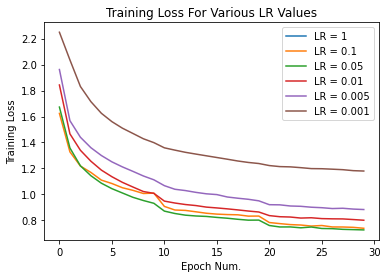

In [ ]:
plt.plot(training_lr_1, label = 'LR = 1')
plt.plot(training_lr_01, label = 'LR = 0.1')
plt.plot(training_lr_005, label = 'LR = 0.05')
plt.plot(training_lr_001, label = 'LR = 0.01')
plt.plot(training_lr_0005, label = 'LR = 0.005')
plt.plot(training_lr_0001, label = 'LR = 0.001')
plt.legend()
plt.xlabel("Epoch Num.")
plt.ylabel("Training Loss")
plt.title("Training Loss For Various LR Values")
plt.show()

In [ ]:
validation_lr_1 = [x.item() for x in validation_losses_all[0]]
validation_lr_01 = [x.item() for x in validation_losses_all[1]]
validation_lr_005 = [x.item() for x in validation_losses_all[2]]
validation_lr_001 = [x.item() for x in validation_losses_all[3]]
validation_lr_0005 = [x.item() for x in validation_losses_all[4]]
validation_lr_0001 = [x.item() for x in validation_losses_all[5]]

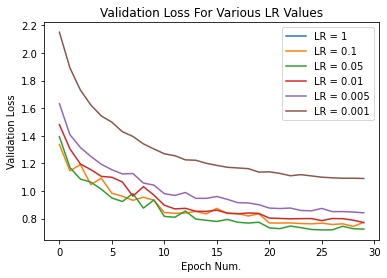

In [ ]:
plt.plot(validation_lr_1, label = 'LR = 1')
plt.plot(validation_lr_01, label = 'LR = 0.1')
plt.plot(validation_lr_005, label = 'LR = 0.05')
plt.plot(validation_lr_001, label = 'LR = 0.01')
plt.plot(validation_lr_0005, label = 'LR = 0.005')
plt.plot(validation_lr_0001, label = 'LR = 0.001')
plt.legend()
plt.xlabel("Epoch Num.")
plt.ylabel("Validation Loss")
plt.title("Validation Loss For Various LR Values")
plt.show()

In [ ]:
table = pd.DataFrame.from_dict({'Learning Rate': ['1', '0.1', '0.05', '0.01', '0.005', '0.001'], 'Best Validation Accuracy': [0.1028, 0.7386, 0.7502, 0.7278, 0.7046, 0.6110]})

In [ ]:
table

,Learning Rate,Best Validation Accuracy
0,1,0.1028
1,0.1,0.7386
2,0.05,0.7502
3,0.01,0.7278
4,0.005,0.7046
5,0.001,0.6110


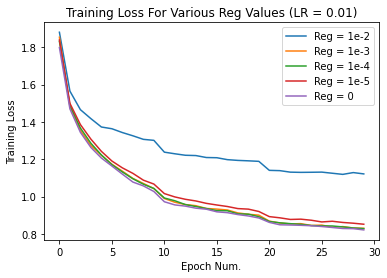

In [ ]:
validation_reg_1e2 = [x.item() for x in validation_losses_all_reg[0]]
validation_reg_1e3 = [x.item() for x in validation_losses_all_reg[1]]
validation_reg_1e4 = [x.item() for x in validation_losses_all_reg[2]]
validation_reg_1e5 = [x.item() for x in validation_losses_all_reg[3]]
validation_reg_0 = [x.item() for x in validation_losses_all_reg[4]]

training_reg_1e2 = [x.item() for x in training_losses_all_reg[0]]
training_reg_1e3 = [x.item() for x in training_losses_all_reg[1]]
training_reg_1e4 = [x.item() for x in training_losses_all_reg[2]]
training_reg_1e5 = [x.item() for x in training_losses_all_reg[3]]
training_reg_0 = [x.item() for x in training_losses_all_reg[4]]

plt.plot(training_reg_1e2, label = 'Reg = 1e-2')
plt.plot(training_reg_1e3, label = 'Reg = 1e-3')
plt.plot(training_reg_1e4, label = 'Reg = 1e-4')
plt.plot(training_reg_1e5, label = 'Reg = 1e-5')
plt.plot(training_reg_0, label = 'Reg = 0')
plt.legend()
plt.xlabel("Epoch Num.")
plt.ylabel("Training Loss")
plt.title("Training Loss For Various Reg Values (LR = 0.01)")
plt.show()

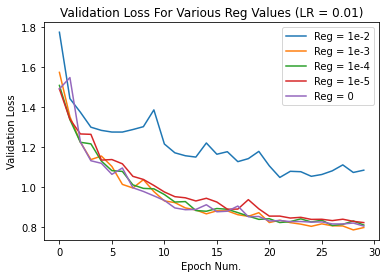

In [ ]:
plt.plot(validation_reg_1e2, label = 'Reg = 1e-2')
plt.plot(validation_reg_1e3, label = 'Reg = 1e-3')
plt.plot(validation_reg_1e4, label = 'Reg = 1e-4')
plt.plot(validation_reg_1e5, label = 'Reg = 1e-5')
plt.plot(validation_reg_0, label = 'Reg = 0')
plt.legend()
plt.xlabel("Epoch Num.")
plt.ylabel("Validation Loss")
plt.title("Validation Loss For Various Reg Values (LR = 0.01)")
plt.show()

In [ ]:
reg_table = pd.DataFrame.from_dict({'Reg Rate': ['1e-2', '1e-3', '1e-4', '1e-5', '0'], 'Best Validation Accuracy': [0.6310, 0.7190, 0.7188, 0.7060, 0.7192]})
reg_table

,Reg Rate,Best Validation Accuracy
0,1e-2,0.6310
1,1e-3,0.7190
2,1e-4,0.7188
3,1e-5,0.7060
4,0,0.7192


In [ ]:
## Part b)

# Showing that batch normalization allows a larger learning rate by increasing the learning rate by 10x.

with_bn_tr_loss = [x.item() for x in bn_training_loss]

In [ ]:
without_bn_tr_loss = [x.item() for x in no_bn_training_loss]

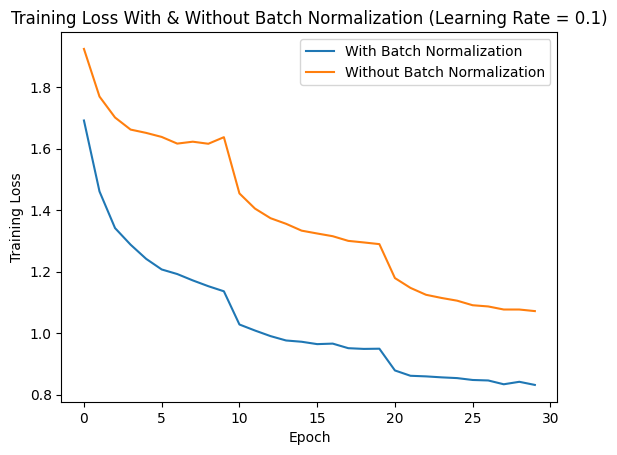

In [ ]:
import matplotlib.pyplot as plt

plt.plot(with_bn_tr_loss, label = 'With Batch Normalization')
plt.plot(without_bn_tr_loss, label = 'Without Batch Normalization')
plt.title("Training Loss With & Without Batch Normalization (Learning Rate = 0.1)")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.show()

# Bonus: with learning rate decay

The following code can help you adjust the learning rate during training. You need to figure out how to incorporate this code into your training loop.
```python
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
```